In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import random
from sklearn.tree import DecisionTreeClassifier

In [346]:
#Rows and Columns in Data Frame
anemiaData.shape

(10182, 17)

In [347]:
# Data Cleaning/ Checking the number of NULL values in each column
anemiaData.isnull().sum()

age                            0
residence                      0
highest_education              0
wealth_index                   0
births_last5_years             0
age_respondent_1st_birth       0
hemoglobin_altitude_smoking    0
mother_anemia_level            0
mosquito_bed_sleeping          0
smoking                        0
status                         0
residing_husband_partner       0
child_put_breast               0
fever_two_weeks                0
hemoglobin_altitude            0
child_anemia_level             0
iron_pills                     0
dtype: int64

In [348]:
anemiaData.rename(columns={'Age in 5-year groups': 'age',
                   'Type of place of residence': 'residence',
                   'Highest educational level': 'highest_education',
                   'Wealth index combined': 'wealth_index',
                   'Births in last five years': 'births_last5_years',
                   'Age of respondent at 1st birth': 'age_respondent_1st_birth',
                   'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                   'Anemia level': 'mother_anemia_level',
                   'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_bed_sleeping',
                   'Smokes cigarettes': 'smoking',
                   'Current marital status': 'status',
                   'Currently residing with husband/partner': 'residing_husband_partner',
                   'When child put to breast': 'child_put_breast',
                   'Had fever in last two weeks': 'fever_two_weeks',
                   'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                   'Anemia level.1': 'child_anemia_level',
                   'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)

In [349]:
#Using Child Anemia Level as the base frame - only include rows with child anemia level indicator
# Filter rows where 'anemia_level_child' column is not null
anemiaData.dropna(subset=['child_anemia_level'],inplace = True)
#Rows and Columns in Data Frame
anemiaData.shape

(10182, 17)

##### We are removing the NULL cases for child_anemial_level as we are predicting the level.
##### If we were to randomly fill in these NULL values, this would affect the prediction of our data

In [350]:
#Checking to see remaining rows with NULL values
anemiaData.isnull().sum()

age                            0
residence                      0
highest_education              0
wealth_index                   0
births_last5_years             0
age_respondent_1st_birth       0
hemoglobin_altitude_smoking    0
mother_anemia_level            0
mosquito_bed_sleeping          0
smoking                        0
status                         0
residing_husband_partner       0
child_put_breast               0
fever_two_weeks                0
hemoglobin_altitude            0
child_anemia_level             0
iron_pills                     0
dtype: int64

In [351]:
#Filling the NULL value of mother_anemia_level
anemiaData['mother_anemia_level'] = anemiaData['mother_anemia_level'].fillna("Not stated")

#Filling the NULL value of residing_husband_partner
anemiaData['residing_husband_partner'] = anemiaData['residing_husband_partner'].fillna("Not stated")

##### For mother_anemia_level and residing_husband_partner, we are unsure how the values might have an outcome on child_anemia level.
##### Hence we shall continue to include them in our Dataset and simply change the NULL values to "Not indicated"

In [352]:
#Convert the NULL value of 'hemoglobin_altitude_smoking' to mean values
mean_hemoglobin_altitude_smoking = anemiaData['hemoglobin_altitude_smoking'].mean()
anemiaData['hemoglobin_altitude_smoking'].fillna(mean_hemoglobin_altitude_smoking, inplace=True)

In [353]:
#For now, filling the NULL value of 'child_put_breast'
anemiaData['child_put_breast'] = anemiaData['child_put_breast'].fillna("Not stated")

In [354]:
#Checking to see remaining rows with NULL values
anemiaData.isnull().sum()

age                            0
residence                      0
highest_education              0
wealth_index                   0
births_last5_years             0
age_respondent_1st_birth       0
hemoglobin_altitude_smoking    0
mother_anemia_level            0
mosquito_bed_sleeping          0
smoking                        0
status                         0
residing_husband_partner       0
child_put_breast               0
fever_two_weeks                0
hemoglobin_altitude            0
child_anemia_level             0
iron_pills                     0
dtype: int64

## Machine Learning using Random Forest + Decision Tree

##### In this step, we will be using the Random Forest predictive model to better understand the pattern in the data.
##### Followed which, we will use the predictive model to predict level of importance of each variable, while also predicting the anemia level of the child

In [355]:
# Creating a copied DataFrame of anemiaData
df = anemiaData.copy()

In [356]:
encoded_unique_categories = {
    'age': df['age'].unique(),
    'residence': df['residence'].unique(),
    'highest_education': df['highest_education'].unique(),
    'wealth_index': df['wealth_index'].unique(),
    'mother_anemia_level': df['mother_anemia_level'].unique(),
    'mosquito_bed_sleeping': df['mosquito_bed_sleeping'].unique(),
    'smoking': df['smoking'].unique(),
    'status': df['status'].unique(),
    'residing_husband_partner': df['residing_husband_partner'].unique(),
    'fever_two_weeks': df['fever_two_weeks'].unique(),
    'iron_pills': df['iron_pills'].unique()
}

print("Unique Categories After Label Encoding:")
for column, categories in encoded_unique_categories.items():
    print(f"{column}: {categories}")


Unique Categories After Label Encoding:
age: ['25-29' '30-34' '35-39' '20-24' '15-19' '45-49' '40-44']
residence: ['Urban' 'Rural']
highest_education: ['Secondary' 'Higher' 'No education' 'Primary']
wealth_index: ['Richest' 'Richer' 'Poorer' 'Middle' 'Poorest']
mother_anemia_level: ['Moderate' 'Mild' 'Not anemic' 'Severe' 'Not stated']
mosquito_bed_sleeping: ['Yes' 'No']
smoking: ['No' 'Yes']
status: ['Married' 'Never in union' 'No longer living together/separated'
 'Widowed' 'Living with partner' 'Divorced']
residing_husband_partner: ['Living with her' 'Staying elsewhere' 'Not stated']
fever_two_weeks: ['No' 'Yes' "Don't know"]
iron_pills: ['No' 'Yes' "Don't know"]


##### Given that most of the variables are categorical variables with multiple classes, we want our DataFrame to reflect the different classes.
##### Intially, our group tried to do One-Hot coding in order to change all the variables(execpt 'child_anemia_level'- target), but constantly met with errors
##### Decided to use Label Encoder Method/Find-replace method, need to do one-by-one

In [357]:
le = LabelEncoder()

df['age'] = le.fit_transform(df['age'])
df['residence'] = le.fit_transform(df['residence'])
df['highest_education'] = le.fit_transform(df['highest_education'])
df['wealth_index'] = le.fit_transform(df['wealth_index'])
df['mother_anemia_level'] = le.fit_transform(df['mother_anemia_level'])
df['mother_anemia_level'] = df['mother_anemia_level'].replace({'Not anemic': '0', 'Mild': '1', 'Moderate': '2', 'Severe': '3'})
df['mosquito_bed_sleeping'] = le.fit_transform(df['mosquito_bed_sleeping'])
df['smoking'] = le.fit_transform(df['smoking'])
df['status'] = le.fit_transform(df['status'])
df['residing_husband_partner'] = le.fit_transform(df['residing_husband_partner'])
df['fever_two_weeks'] = le.fit_transform(df['fever_two_weeks'])
df['iron_pills'] = le.fit_transform(df['iron_pills'])


In [358]:
df['child_anemia_level'] = df['child_anemia_level'].replace({'Not anemic': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3})

#### Dropping certain variables
##### Upon Basic Data Vizsualisation and EDA, we realised the need to drop certain variables due to skewness of the data (Too many of 1 level)
##### Applicable for 'smoking' & 'status'
##### Additionally, we decided to drop 'child_put_breast'.The row consisted of numerical and categorical data with minimal definition on kaggle, thus because our grp is unsure, we decided to drop the data.

In [359]:
df.drop('child_put_breast', axis=1, inplace=True)
df.drop('smoking', axis=1, inplace=True)
df.drop('status', axis=1, inplace=True)

In [360]:
df.head()

age  residence  highest_education  wealth_index  births_last5_years  \
3     2          1                  3             4                   1   
5     3          1                  0             4                   1   
6     4          1                  3             4                   2   
9     1          1                  3             4                   1   
12    2          1                  0             4                   1   

    age_respondent_1st_birth  hemoglobin_altitude_smoking  \
3                         25                         95.0   
5                         30                        113.0   
6                         32                        121.0   
9                         19                        108.0   
12                        24                        116.0   

    mother_anemia_level  mosquito_bed_sleeping  residing_husband_partner  \
3                     1                      1                         0   
5                     0                      1                         0   
6                     2                      1                         0   
9                     1                      1                         0   
12                    0                      1                         0   

    fever_two_weeks  hemoglobin_altitude  child_anemia_level  iron_pills  
3                 1                114.0                   0           1  
5                 1                119.0                   0           1  
6                 1                102.0                   1           2  
9                 1                113.0                   0           2  
12                1                109.0                   1           1

In [361]:
# Observing the Data Types in the DataFrame
df.dtypes

age                              int32
residence                        int32
highest_education                int32
wealth_index                     int32
births_last5_years               int64
age_respondent_1st_birth         int64
hemoglobin_altitude_smoking    float64
mother_anemia_level              int32
mosquito_bed_sleeping            int32
residing_husband_partner         int32
fever_two_weeks                  int32
hemoglobin_altitude            float64
child_anemia_level               int64
iron_pills                       int32
dtype: object

In [362]:
# Response Variable
y = df['child_anemia_level']
y.shape

(10182,)

In [363]:
# Predictor Variables
x = df.drop(['child_anemia_level'],axis = 1)
x.shape

(10182, 13)

In [364]:
#Splitting train/test in 75/25 ratio
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25,random_state=45)

In [365]:
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (7636, 13)
Training Labels Shape: (7636,)
Testing Features Shape: (2546, 13)
Testing Labels Shape: (2546,)


In [366]:
rf_train = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_train.fit(x_train,y_train)

rf_test = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_test.fit(x_test,y_test)

rf_all = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_all.fit(x,y)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=45)

##### Calculating metrics of Random Forest Model

In [367]:
print('Evaluating Train Model')
# Access the OOB Score
oob_score = rf_train.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions_train = rf_train.predict(x_train)
 
# Evaluating the model
mse_train = mean_squared_error(y_train, predictions_train)
print(f'Mean Squared Error: {mse_train}')
 
r2 = r2_score(y_train, predictions_train)
print(f'R-squared: {r2}')

print()

print('Evaluating Test Model')
# Access the OOB Score
oob_score = rf_test.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions_test = rf_test.predict(x_test)
 
# Evaluating the model
mse_test = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error: {mse_test}')
 
r2 = r2_score(y_test, predictions_test)
print(f'R-squared: {r2}')

print()

print('Evaluating Overall Model')
# Access the OOB Score
oob_score = rf_all.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = rf_all.predict(x)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')


Evaluating Train Model
Out-of-Bag Score: 0.998821372446307
Mean Squared Error: 0.0
R-squared: 1.0

Evaluating Test Model
Out-of-Bag Score: 0.9968578161822467
Mean Squared Error: 0.0
R-squared: 1.0

Evaluating Overall Model
Out-of-Bag Score: 0.9993125122765665
Mean Squared Error: 0.0
R-squared: 1.0


##### Refering to online research, we incoporated the OOB score as it measures the model's generalization performance
##### It offers the advantage wherby the validation data is not seen by the bagging algorithm and that is why the results on the OOB score are the true results that indicated the actual performance of the bagging algorithm

##### Generally, refering to the current model alone, our data appears to be very accurate with low MSE and high R^2 values

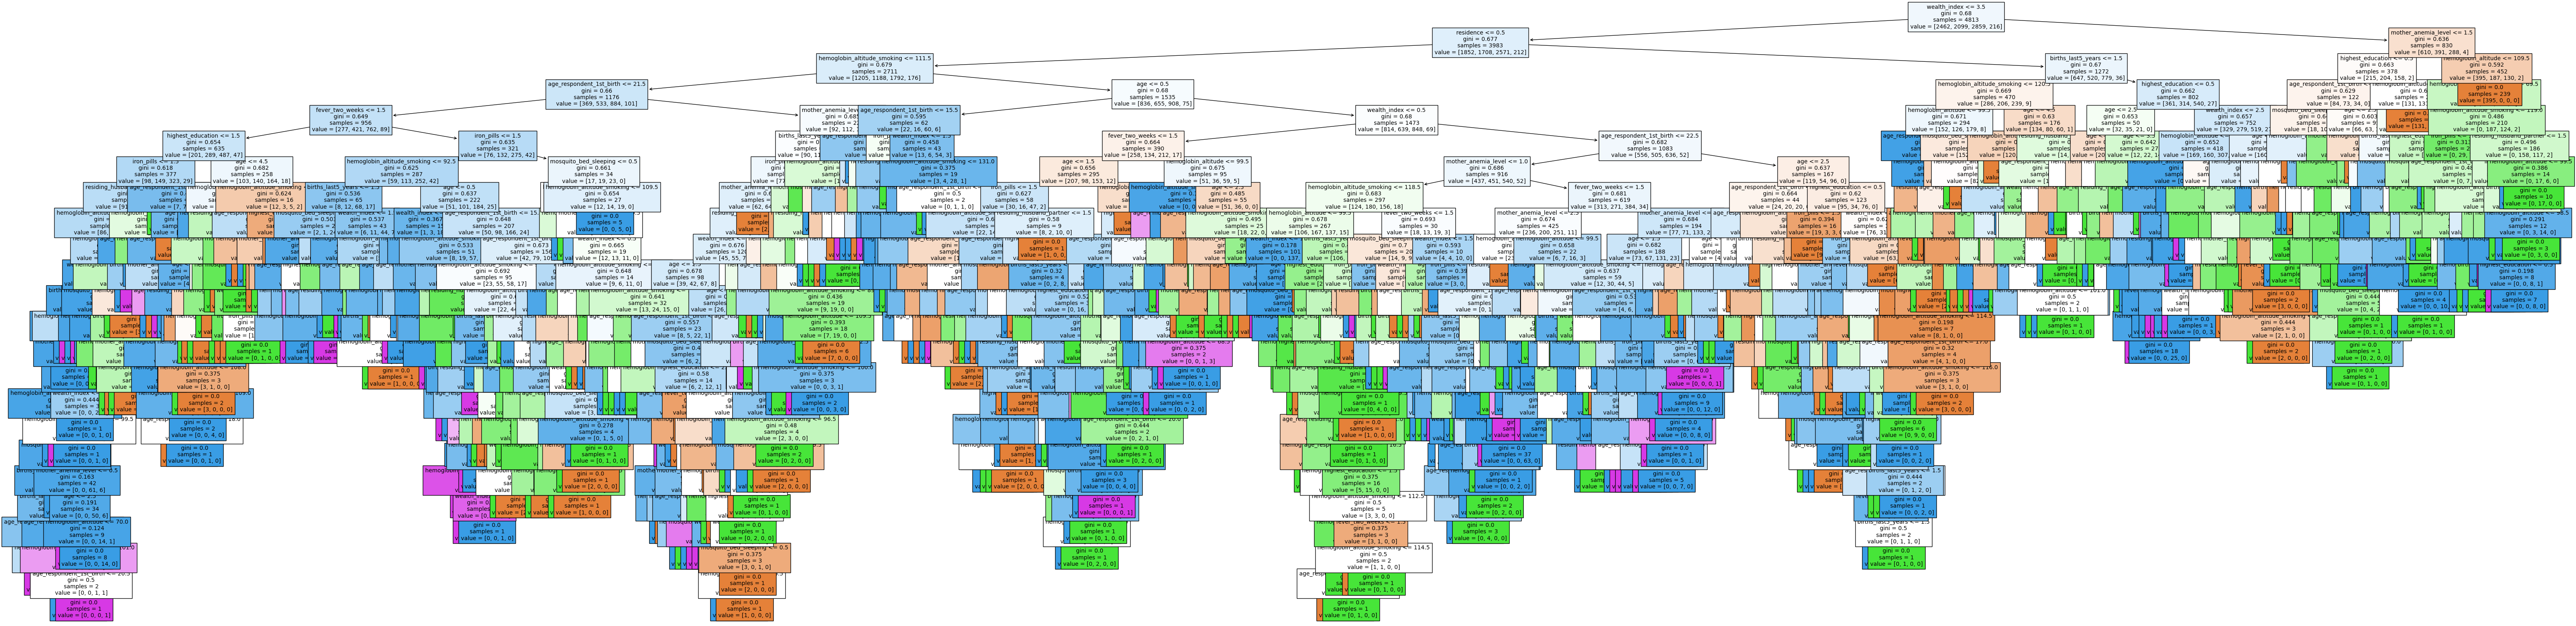

In [368]:
#### Plotting Tree of the Random Forest Model
# Pull out one tree from the forest
tree = rf_train.estimators_[0]

# Convert the Index object to a list
feature_names = list(x.columns)

# Plot the decision tree
plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=feature_names, filled=True, fontsize=10)
plt.show()

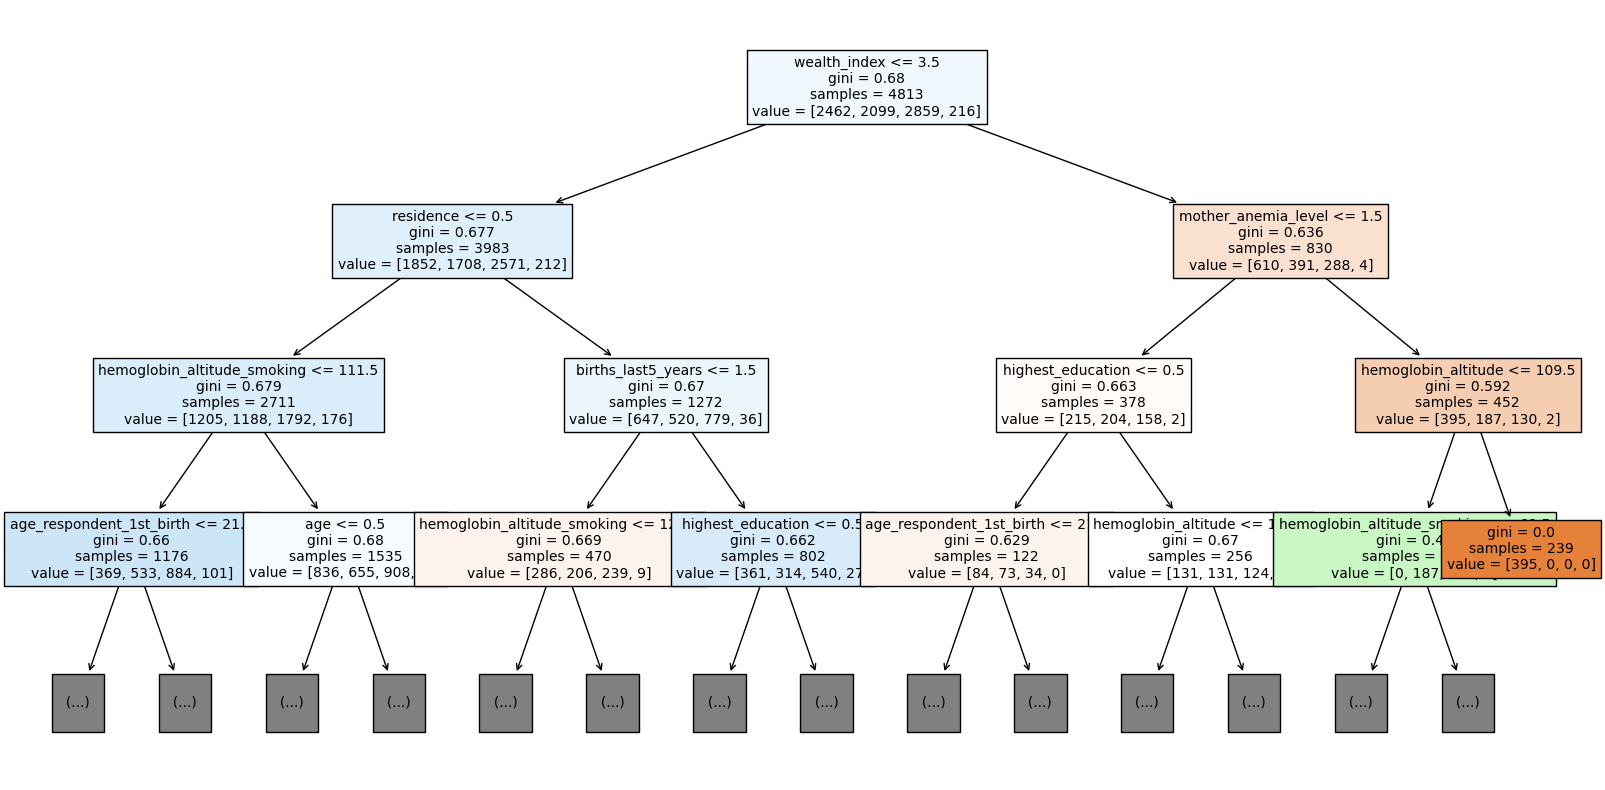

In [369]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_names, filled=True, fontsize=10, max_depth = 3)
plt.show()

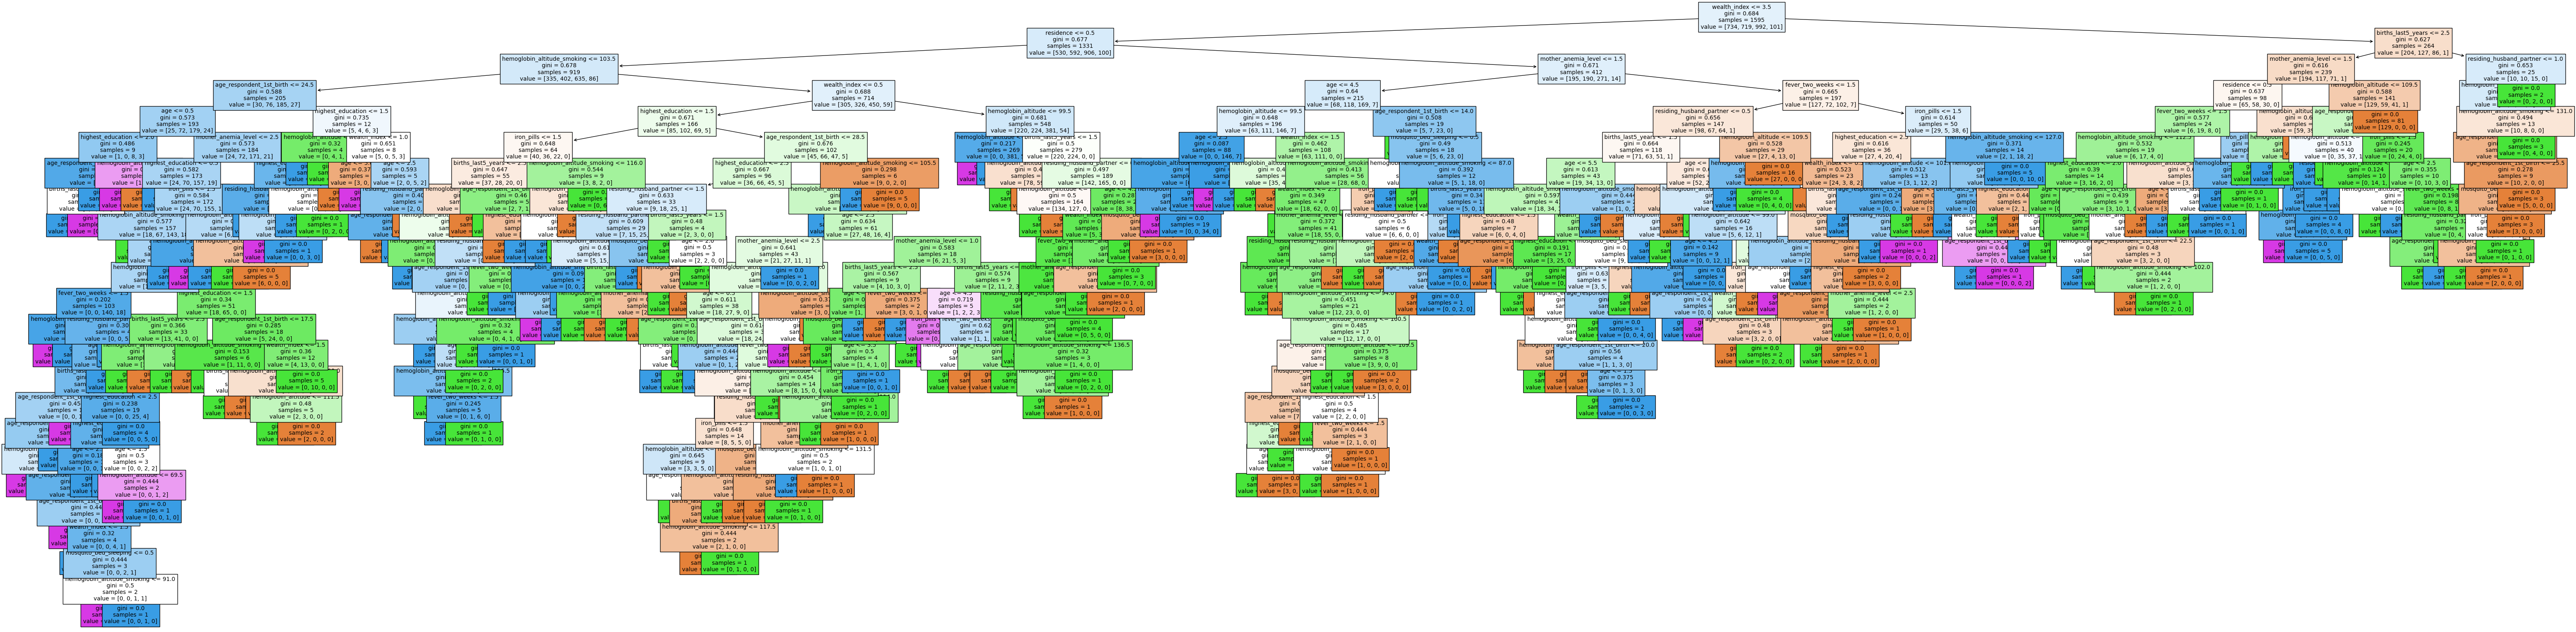

In [370]:
tree = rf_test.estimators_[0]

# Plot the decision tree
plt.figure(figsize=(80, 20))
plot_tree(tree, feature_names=feature_names, filled=True, fontsize=10)
plt.show()

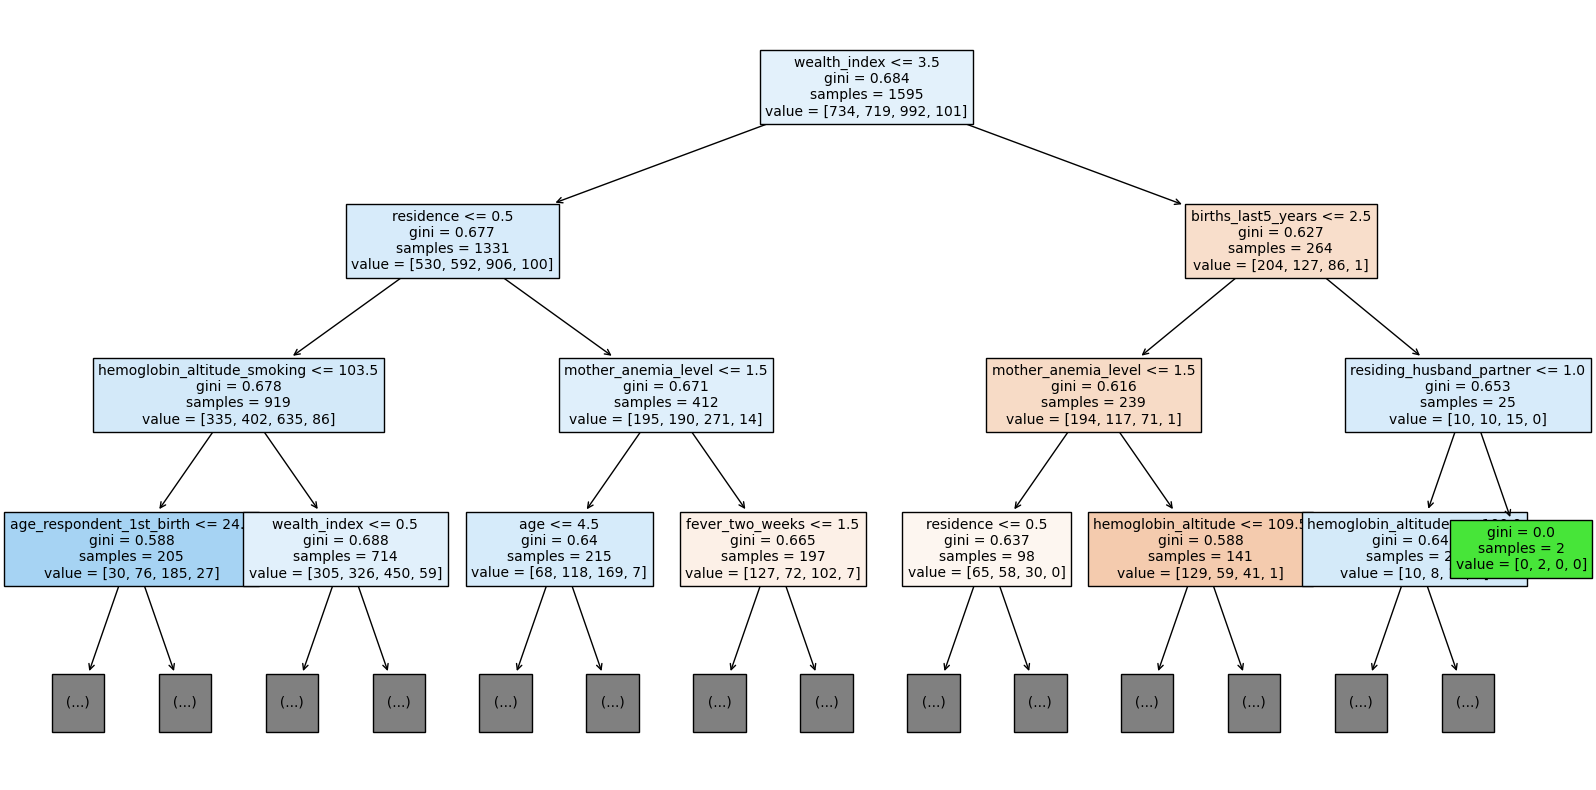

In [371]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=feature_names, filled=True, fontsize=10, max_depth = 3)
plt.show()

##### Randomly selecting a tree in the random forest model for observation^
##### Plotting the whole tree and another with depth of 3

#### Now, we shall analyse the Goodness of Fit of both the Train and Test Model

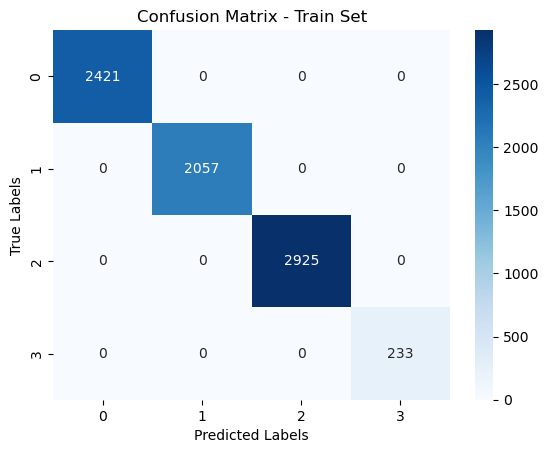

Goodness of Fit - Train Model
Classification Accuracy: 1.0
False Positive Rate (FPR): 0.0
True Positive Rate (TPR): 1.0
False Negative Rate (FNR): 0.0
True Negative Rate (TNR): 1.0


In [372]:
from sklearn.metrics import confusion_matrix
y_pred_train = rf_train.predict(x_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Train Set')
plt.show()

correct_predictions = np.diag(conf_matrix).sum()
total_predictions = conf_matrix.sum()
accuracy = correct_predictions / total_predictions

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

num_classes = len(conf_matrix)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes

print("Goodness of Fit - Train Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

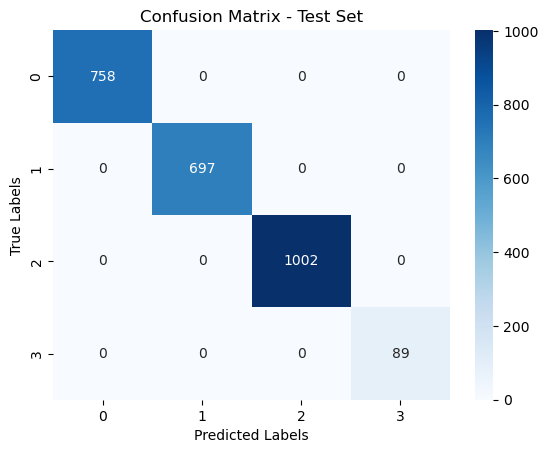

Goodness of Fit - Test Model
Classification Accuracy: 1.0
False Positive Rate (FPR): 0.0
True Positive Rate (TPR): 1.0
False Negative Rate (FNR): 0.0
True Negative Rate (TNR): 1.0


In [373]:
from sklearn.metrics import confusion_matrix
y_pred_test = rf_test.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

correct_predictions = np.diag(conf_matrix).sum()
total_predictions = conf_matrix.sum()
accuracy = correct_predictions / total_predictions

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

num_classes = len(conf_matrix)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes

print("Goodness of Fit - Test Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

##### Refering to the Goodness of Fit Metric of the Train & Test Set, we can establish that our random forest model is very accurate
##### This can be obeserved through the high TP & TN rates and low FP & FN rates.
##### Thus, it can be conclusively mentioned that our model is very accurate

In [374]:
# Get numerical feature importances
importances = list(rf_all.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

print("Order of feature/predictor importance")
print()
# Print out the feature and importances with numbers
for i, pair in enumerate(feature_importances, start=1):
    print(f"{i} : {pair[0]:<13} ")

Order of feature/predictor importance

1 : hemoglobin_altitude 
2 : hemoglobin_altitude_smoking 
3 : age_respondent_1st_birth 
4 : age           
5 : highest_education 
6 : wealth_index  
7 : births_last5_years 
8 : mother_anemia_level 
9 : residence     
10 : mosquito_bed_sleeping 
11 : residing_husband_partner 
12 : fever_two_weeks 
13 : iron_pills    


Variable Importances:
hemoglobin_altitude - 0.88
hemoglobin_altitude_smoking - 0.03
age_respondent_1st_birth - 0.02
age - 0.01
highest_education - 0.01
wealth_index - 0.01
births_last5_years - 0.01
mother_anemia_level - 0.01
residence - 0.0
mosquito_bed_sleeping - 0.0
residing_husband_partner - 0.0
fever_two_weeks - 0.0
iron_pills - 0.0


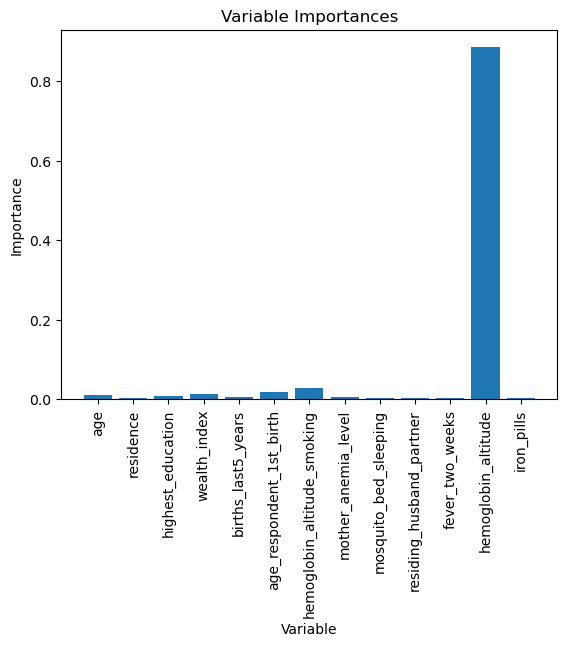

In [375]:

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


print("Variable Importances:")
for feature, importance in feature_importances:
    print(f"{feature} - {importance:}")

##### A deeper look into the data, we can observe the most significant predictor/feature in our model is actually the 'hemoglobin_altitude'
##### As of this point we have addressed the importance of each variable in the prediction of 'child_anemia-level'
##### However, before conclusively justifying this model and predictor, we shall recreate the model with this feature as the only predictor in our model
##### Thus we will make use of a decision tree

In [376]:
x = pd.DataFrame(df['hemoglobin_altitude'])
print(x.shape)
y = pd.DataFrame(df['child_anemia_level'])
print(y.shape)

(10182, 1)
(10182, 1)


In [377]:
#Splitting train/test in 75/25 ratio
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25,random_state=45)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (7636, 1)
Training Labels Shape: (7636, 1)
Testing Features Shape: (2546, 1)
Testing Labels Shape: (2546, 1)


In [378]:
# create the train model decision tree object
dectree_train = DecisionTreeClassifier(random_state=45)  
dectree_train.fit(x_train, y_train)

 # create the test model decision tree object
dectree_test = DecisionTreeClassifier(random_state=45) 
dectree_test.fit(x_train, y_train)

DecisionTreeClassifier(random_state=45)

[Text(0.5, 0.8333333333333334, 'hemoglobin_altitude <= 99.5\ngini = 0.679\nsamples = 7636\nvalue = [2421, 2057, 2925, 233]'),
 Text(0.25, 0.5, 'hemoglobin_altitude <= 69.5\ngini = 0.137\nsamples = 3158\nvalue = [0, 0, 2925, 233]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 233\nvalue = [0, 0, 0, 233]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 2925\nvalue = [0, 0, 2925, 0]'),
 Text(0.75, 0.5, 'hemoglobin_altitude <= 109.5\ngini = 0.497\nsamples = 4478\nvalue = [2421, 2057, 0, 0]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 2057\nvalue = [0, 2057, 0, 0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 2421\nvalue = [2421, 0, 0, 0]')]

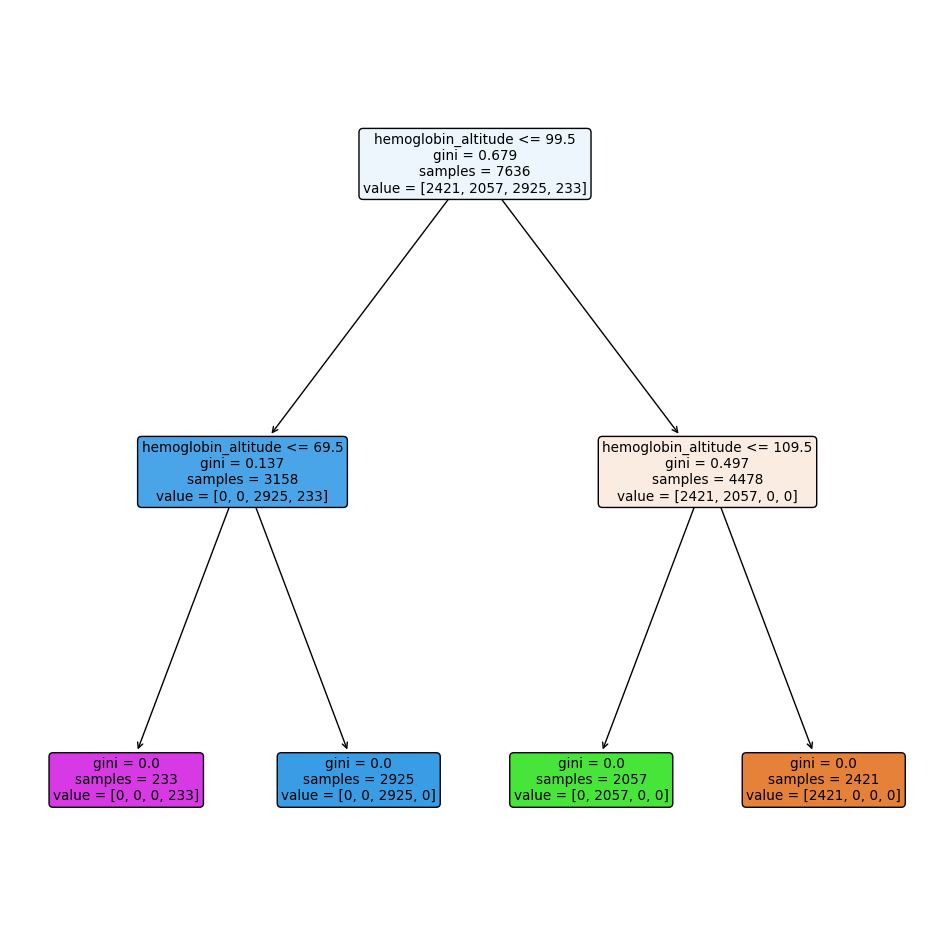

In [379]:
f = plt.figure(figsize=(12,12))
plot_tree(dectree_train, filled=True, rounded=True, feature_names = ["hemoglobin_altitude"])

[Text(0.5, 0.8333333333333334, 'hemoglobin_altitude <= 99.5\ngini = 0.679\nsamples = 7636\nvalue = [2421, 2057, 2925, 233]'),
 Text(0.25, 0.5, 'hemoglobin_altitude <= 69.5\ngini = 0.137\nsamples = 3158\nvalue = [0, 0, 2925, 233]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.0\nsamples = 233\nvalue = [0, 0, 0, 233]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 2925\nvalue = [0, 0, 2925, 0]'),
 Text(0.75, 0.5, 'hemoglobin_altitude <= 109.5\ngini = 0.497\nsamples = 4478\nvalue = [2421, 2057, 0, 0]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 2057\nvalue = [0, 2057, 0, 0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 2421\nvalue = [2421, 0, 0, 0]')]

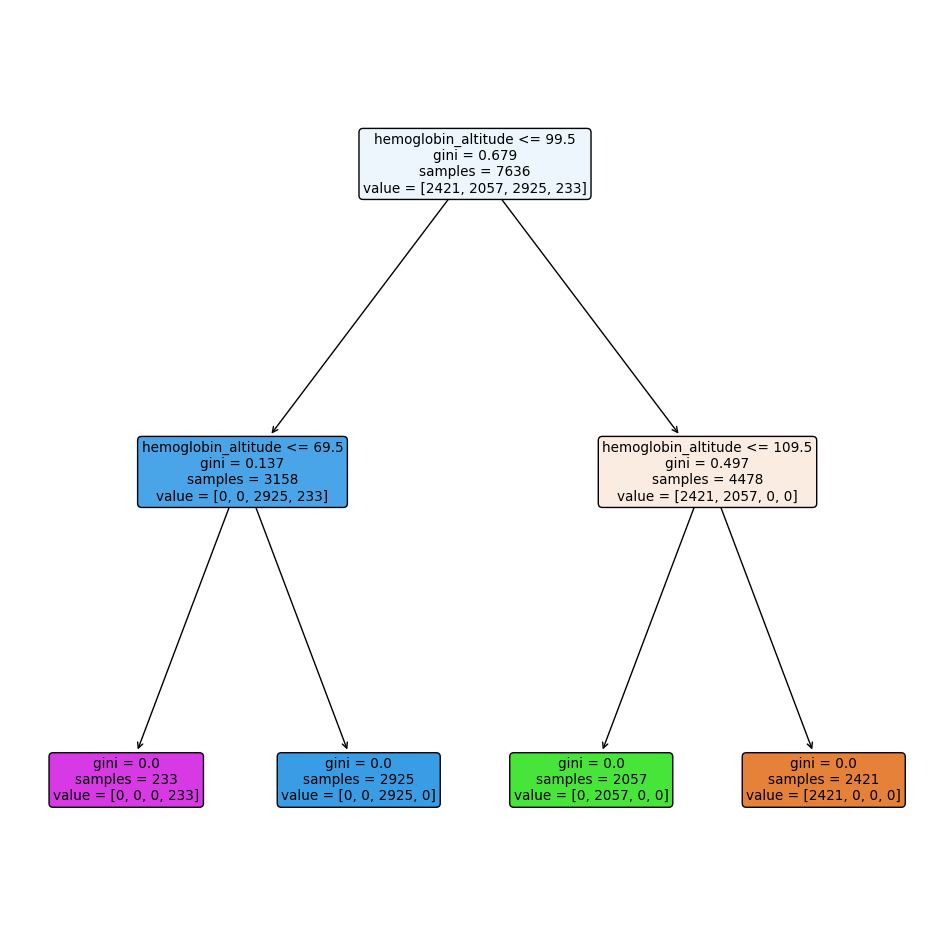

In [380]:
f = plt.figure(figsize=(12,12))
plot_tree(dectree_test, filled=True, rounded=True, 
          feature_names= ["hemoglobin_altitude"])

Goodness of Fit - Train Model
Classification Accuracy: 1.0
False Positive Rate (FPR): 0.0
True Positive Rate (TPR): 1.0
False Negative Rate (FNR): 0.0
True Negative Rate (TNR): 1.0

Goodness of Fit - Test Model
Classification Accuracy: 1.0
False Positive Rate (FPR): 0.0
True Positive Rate (TPR): 1.0
False Negative Rate (FNR): 0.0
True Negative Rate (TNR): 1.0


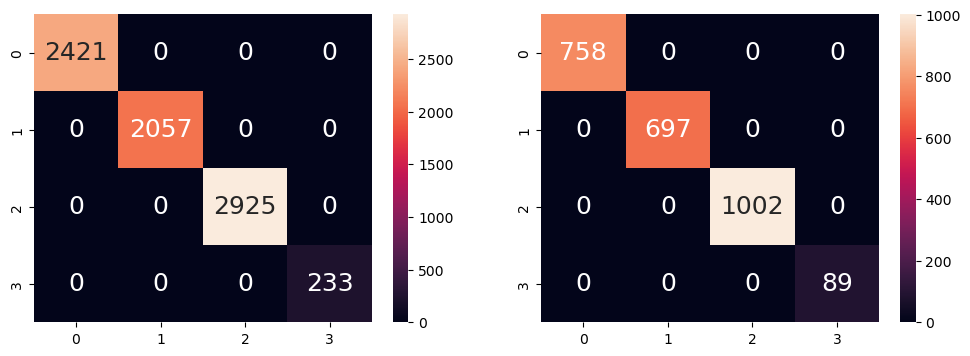

In [381]:
y_train_pred = dectree_train.predict(x_train)
y_test_pred = dectree_test.predict(x_test)

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

CM_train = confusion_matrix(y_train, y_train_pred)

correct_predictions = np.diag(CM_train).sum()
total_predictions = CM_train.sum()
accuracy = correct_predictions / total_predictions

FP = CM_train.sum(axis=0) - np.diag(CM_train)  
FN = CM_train.sum(axis=1) - np.diag(CM_train)
TP = np.diag(CM_train)
TN = CM_train.sum() - (FP + FN + TP)

num_classes = len(CM_train)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes

print("Goodness of Fit - Train Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

print()

CM_test = confusion_matrix(y_test, y_test_pred)

correct_predictions = np.diag(CM_test).sum()
total_predictions = CM_test.sum()
accuracy = correct_predictions / total_predictions

FP = CM_test.sum(axis=0) - np.diag(CM_test)  
FN = CM_test.sum(axis=1) - np.diag(CM_test)
TP = np.diag(CM_test)
TN = CM_test.sum() - (FP + FN + TP)

num_classes = len(CM_test)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes


print("Goodness of Fit - Test Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

#### Having Observed that the classification accuracy is soo high, our Group believes that there may be possible overfitting in data.
##### We shall run another random forest model without the 'hemoglobin_altitude variable)'

In [382]:
x = df.drop(['child_anemia_level','hemoglobin_altitude'],axis = 1)
y = df['child_anemia_level']
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25,random_state=45)
print('Training Features Shape:', x_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', x_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (7636, 12)
Training Labels Shape: (7636,)
Testing Features Shape: (2546, 12)
Testing Labels Shape: (2546,)


In [383]:
x.dtypes

age                              int32
residence                        int32
highest_education                int32
wealth_index                     int32
births_last5_years               int64
age_respondent_1st_birth         int64
hemoglobin_altitude_smoking    float64
mother_anemia_level              int32
mosquito_bed_sleeping            int32
residing_husband_partner         int32
fever_two_weeks                  int32
iron_pills                       int32
dtype: object

In [384]:
rf_train = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_train.fit(x_train,y_train)

rf_test = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_test.fit(x_test,y_test)

rf_all = RandomForestClassifier(random_state=45,n_jobs=-1,oob_score = True)
rf_all.fit(x,y)

print('Evaluating Train Model')
# Access the OOB Score
oob_score = rf_train.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions_train = rf_train.predict(x_train)
 
# Evaluating the model
mse_train = mean_squared_error(y_train, predictions_train)
print(f'Mean Squared Error: {mse_train}')
 
r2 = r2_score(y_train, predictions_train)
print(f'R-squared: {r2}')

print()

print('Evaluating Test Model')
# Access the OOB Score
oob_score = rf_test.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions_test = rf_test.predict(x_test)
 
# Evaluating the model
mse_test = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error: {mse_test}')
 
r2 = r2_score(y_test, predictions_test)
print(f'R-squared: {r2}')

print()

print('Evaluating Overall Model')
# Access the OOB Score
oob_score = rf_all.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = rf_all.predict(x)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')


Evaluating Train Model
Out-of-Bag Score: 0.4093766369827135
Mean Squared Error: 0.1744368779465689
R-squared: 0.783582877774049

Evaluating Test Model
Out-of-Bag Score: 0.40377062058130403
Mean Squared Error: 0.0636292223095051
R-squared: 0.92082318152395

Evaluating Overall Model
Out-of-Bag Score: 0.40895698291101945
Mean Squared Error: 0.21901394617953251
R-squared: 0.7281713391651032


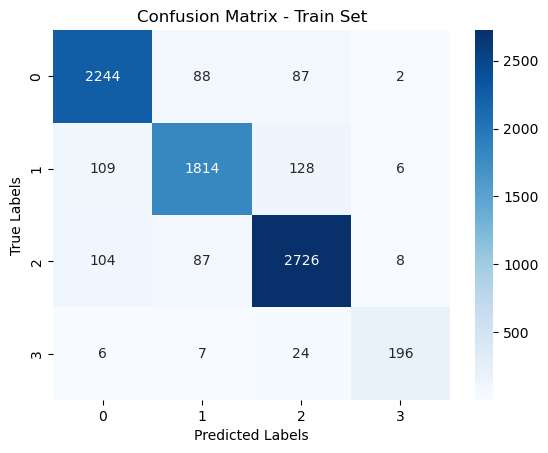

Goodness of Fit - Train Model
Classification Accuracy: 0.9140911471974856
False Positive Rate (FPR): 0.031877548918187004
True Positive Rate (TPR): 0.8954810100007782
False Negative Rate (FNR): 0.10451898999922185
True Negative Rate (TNR): 0.9681224510818129


In [385]:
y_pred_train = rf_train.predict(x_train)
conf_matrix = confusion_matrix(y_train, y_pred_train)
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Train Set')
plt.show()

correct_predictions = np.diag(conf_matrix).sum()
total_predictions = conf_matrix.sum()
accuracy = correct_predictions / total_predictions

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Calculate rates
num_classes = len(conf_matrix)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes

# Print rates
print("Goodness of Fit - Train Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

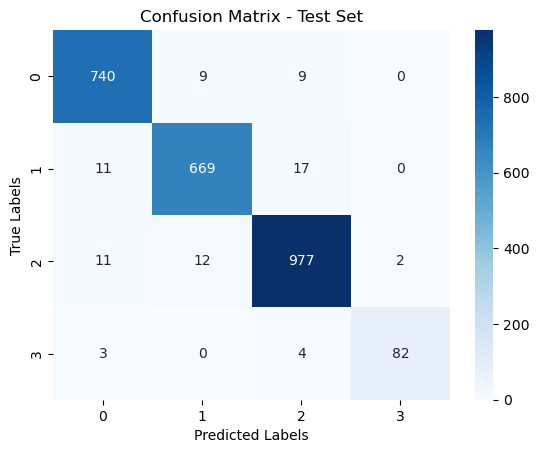

Goodness of Fit - Test Model
Classification Accuracy: 0.969363707776905
False Positive Rate (FPR): 0.011395911517793568
True Positive Rate (TPR): 0.9581198366329575
False Negative Rate (FNR): 0.041880163367042485
True Negative Rate (TNR): 0.9886040884822064


In [386]:
y_pred_test = rf_test.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

correct_predictions = np.diag(conf_matrix).sum()
total_predictions = conf_matrix.sum()
accuracy = correct_predictions / total_predictions

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)  
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)

# Calculate rates
num_classes = len(conf_matrix)
FPR = sum(FP / (FP + TN)) / num_classes
TPR = sum(TP / (TP + FN)) / num_classes
FNR = sum(FN / (FN + TP)) / num_classes
TNR = sum(TN / (TN + FP)) / num_classes

# Print rates
print("Goodness of Fit - Test Model")
print("Classification Accuracy:", accuracy)
print("False Positive Rate (FPR):", FPR)
print("True Positive Rate (TPR):", TPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

Order of feature/predictor importance

1 : hemoglobin_altitude_smoking Importance: 0.25
2 : age_respondent_1st_birth Importance: 0.2
3 : age          Importance: 0.13
4 : wealth_index Importance: 0.08
5 : births_last5_years Importance: 0.07
6 : highest_education Importance: 0.06
7 : mosquito_bed_sleeping Importance: 0.04
8 : residing_husband_partner Importance: 0.04
9 : iron_pills   Importance: 0.04
10 : residence    Importance: 0.03
11 : mother_anemia_level Importance: 0.03
12 : fever_two_weeks Importance: 0.03


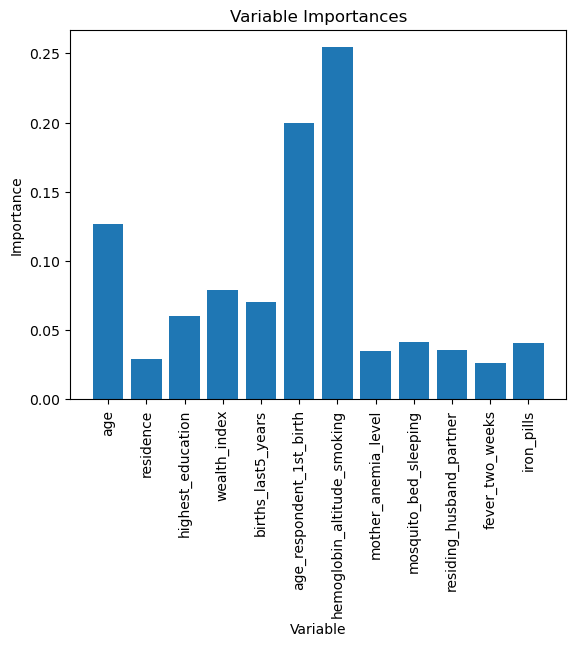

In [387]:
feature_names = list(x.columns)
# Get numerical feature importances
importances = list(rf_all.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

print("Order of feature/predictor importance")
print()
# Print out the feature and importances with numbers
for i, pair in enumerate(feature_importances, start=1):
    print(f"{i} : {pair[0]:<12} Importance: {pair[1]}")

x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');


#### Though this model appears to be less accurate compared to the original, it allows us to see the importance of the other variables in relative to each other.
#### Additionally, through research and consults, we learnt that in our first model, the accuracy was very high, which could be attributed to the distribution of 'hemoglobin_altitude' being soo close to normal

#### Through the use of the random forest model, we were able to achieve our first goal on establishing which are the most important features in predicting anemia level of a child

### Now let us move on to use Support Vector Machine learning to achieve our next goal to predict the exact anemia level of a child